In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web8.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web4.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web6.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web2.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web5.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web1.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web3.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web7.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/7/web9.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/17/web8.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/17/web4.png
/kaggle/input/product-recoginition/Product Recoginition/Training Data/17/web6.png
/kaggle/input/product-rec

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found Validation
Anchor shape: (256, 224, 224, 3)
Positive shape: (256, 224, 224, 3)
Negative shape: (256, 224, 224, 3)
Anchor shape: (256, 224, 224, 3)
Positive shape: (256, 224, 224, 3)
Negative shape: (256, 224, 224, 3)
Anchor shape: (188, 224, 224, 3)
Positive shape: (188, 224, 224, 3)
Negative shape: (188, 224, 224, 3)
Found Validation
83683744/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                      

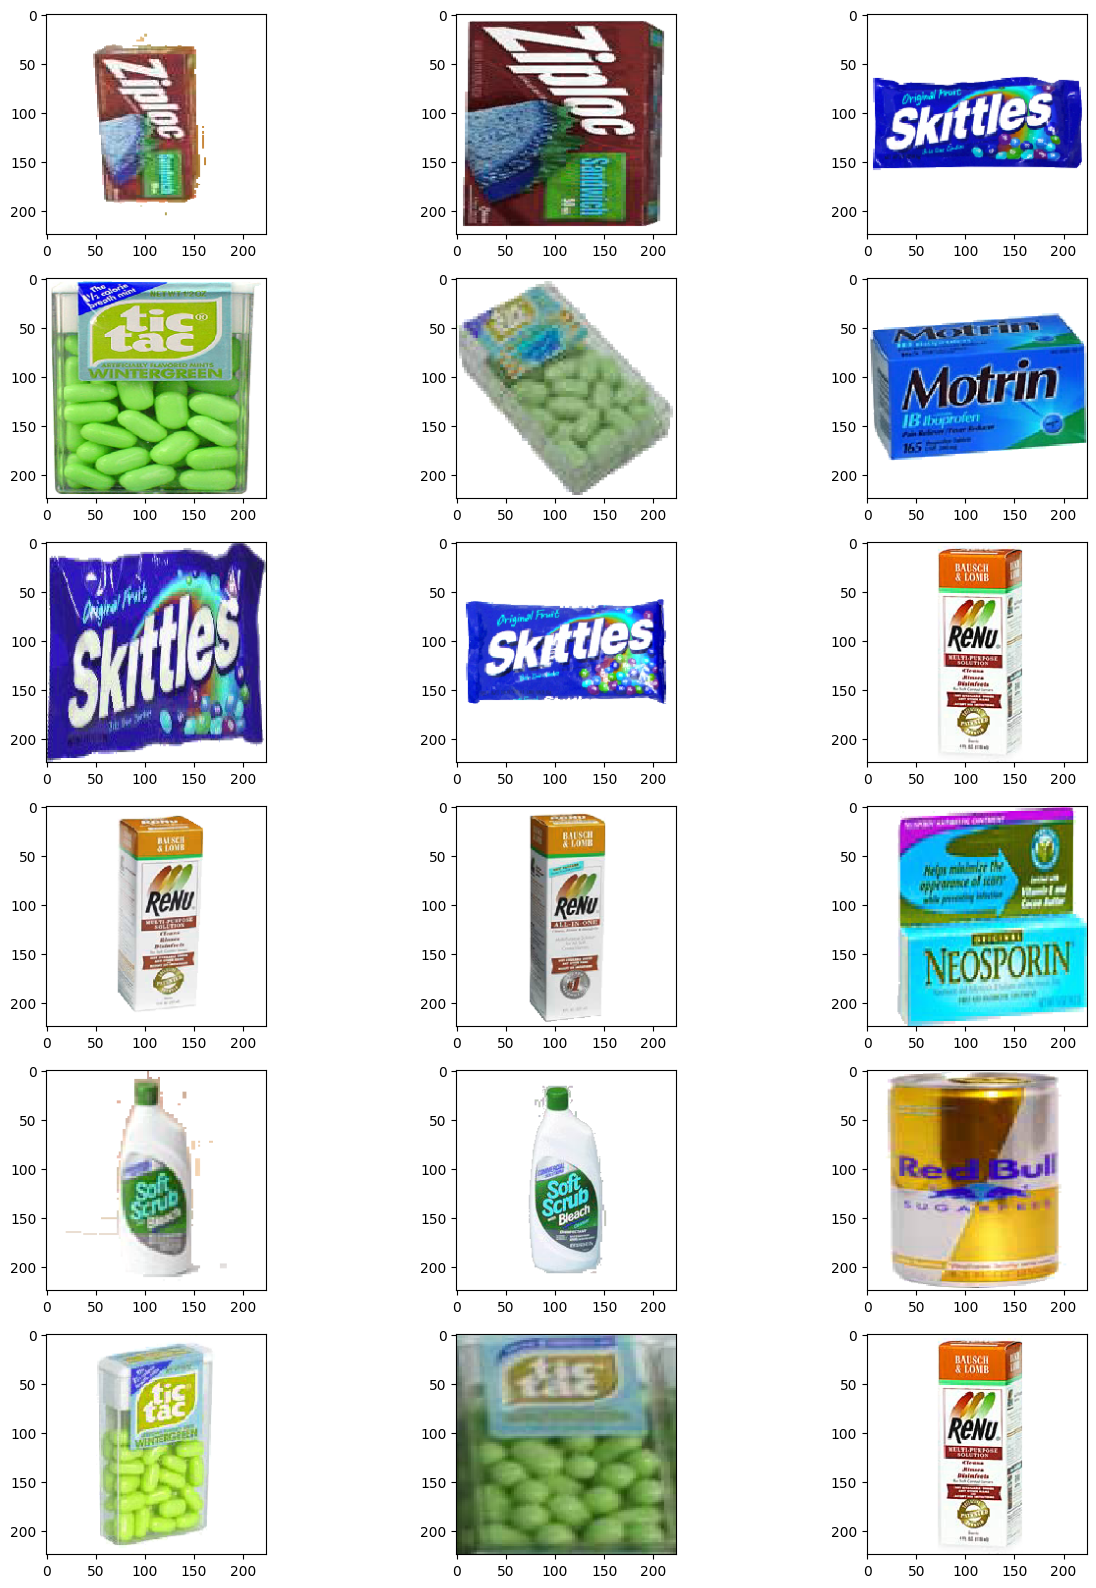

In [2]:
import os
import cv2
import time
import random
import numpy as np
import tensorflow as tf  # building and training deep learning models
from tensorflow.keras.applications.inception_v3 import preprocess_input  # preprocessing input data for the neural network
import seaborn as sns  # statistical graphics
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# Kaggle dataset path
ROOT = "/kaggle/input/product-recoginition/Product Recoginition"


def read_image(index, data_type="Training Data", image_format="png"):
    assert data_type in ["Training Data", "Validation Data"], "Invalid data type"

    folder_number = index[0]
    image_index = index[1]

    if data_type == "Training Data":
        path = os.path.join(ROOT, "Training Data", str(folder_number), f"web{image_index}.{image_format}")
    else:
        path = os.path.join(ROOT, "Validation Data", str(folder_number), f"web{image_index}.{image_format}")

    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None

    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)

    return image


def split_dataset(directory, split=0.9):
    subdirectories = os.listdir(directory)

    # Assuming subdirectories are named as "Training Data" and "Validation Data"
    train_directory = os.path.join(directory, "Training Data")
    val_directory = os.path.join(directory, "Validation Data")

    # Get the list of folders in each subdirectory
    train_folders = os.listdir(train_directory)
    val_folders = os.listdir(val_directory)

    num_train = int(len(train_folders) * split)

    random.shuffle(train_folders)

    train_list, val_list = {}, {}

    # Creating Train-list
    for folder in train_folders[:num_train]:
        image_files = [file for file in os.listdir(os.path.join(train_directory, folder)) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        num_files = len(image_files)
        train_list[folder] = num_files

    # Creating Validation-list
    for folder in val_folders:
        image_files = [file for file in os.listdir(os.path.join(val_directory, folder)) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        num_files = len(image_files)
        val_list[folder] = num_files

    return train_list, val_list



def create_triplets(directory, folder_list, data_type="Training Data", max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    if data_type =="Validation Data":
        print("Found Validation")
    for folder in folders:
        path = os.path.join(directory, data_type, folder)


        # Skip if the folder doesn't exist in the specified data type
        if not os.path.exists(path):
            print(f"Folder '{folder}' not found in '{data_type}' data type.")
            continue

        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(1, num_files):
            for j in range(i + 1, num_files):
                anchor = (folder, f"{i}")
                positive = (folder, f"{j}")

                # Ensure that negative folder is from the correct data type
                neg_data_type = "Training Data" if data_type == "Validation Data" else "Validation Data"
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(1, folder_list[neg_folder])
                negative = (neg_folder, f"{neg_file}")
                if folder == '25':
                    if anchor==7 or positive==7:
                       print("Here")
                if neg_folder=='25' and neg_file==7:
                    print("Here")
                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets
train_list, val_list = split_dataset(ROOT)


# Assuming you have defined the train_list and test_list
train_triplet = create_triplets(ROOT, train_list)
val_triplet = create_triplets(ROOT, val_list, data_type="Validation Data")

def get_batch(triplet_list, dataType, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list) // batch_size

    for i in range(batch_steps + 1):
        anchor = []
        positive = []
        negative = []

        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a,dataType))
            positive.append(read_image(p,dataType))
            negative.append(read_image(n,dataType))
            j += 1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

# Example usage
for batch in get_batch(train_triplet, dataType="Training Data",batch_size=256):
    print("Anchor shape:", batch[0].shape)
    print("Positive shape:", batch[1].shape)
    print("Negative shape:", batch[2].shape)

#uncomment this plot statements
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet,  dataType="Training Data",batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

#test the encoder here
#input_shape = (224, 224, 3)
#encoder_model = get_encoder(input_shape)
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape=(224, 224, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    # Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()([encoded_a, encoded_p, encoded_n])

    # Creating the Model
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=distances,
        name="Siamese_Network"
    )
    return siamese_network
train_list, val_list = split_dataset(ROOT)

# Assuming you have defined train_list and val_list
train_triplet = create_triplets(ROOT, train_list)
val_triplet = create_triplets(ROOT, val_list, data_type="Validation Data")

siamese_network = get_siamese_network()
siamese_network.summary()

plot_model(siamese_network, show_shapes=True, show_layer_names=True)

class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

#start of the zft
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []
    dataType = "Validation Data"

    for data in get_batch(val_triplet, dataType,batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

save_all = False
epochs = 30
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, dataType= "Training Data",batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")

In [3]:
def extract_encoder(model):
    encoder = get_encoder((224, 224, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [4]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

6/6 [==============================] - 0s 68ms/step

Accuracy of model: 0.8401162790697675



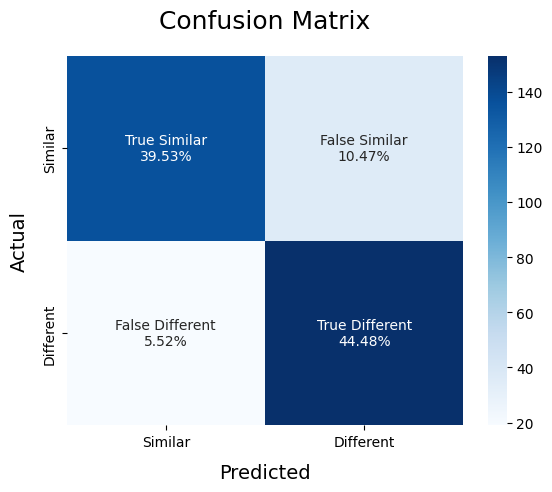

In [5]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(val_triplet,dataType="Validation Data" , batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [6]:
# Print accuracy on train
train_accuracy = test_on_triplets(batch_size=batch_size, dataType="Training Data")[0]
print(f"Accuracy on train = {train_accuracy:.5f}")

TypeError: test_on_triplets() got an unexpected keyword argument 'dataType'